# Title

In [2]:
# The different packages we used to work on the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import itertools

from trueskill import Rating, rate_1vs1, quality_1vs1
from trueskill import BETA
from trueskill.backends import cdf

## 1. Dataset
For our project we used only the *results.csv* dataset. It includes all the information we needed, like the result of a match.

In [3]:
results = pd.read_csv('./data/results.csv')
results.tail(10)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
45090,2023-10-17,Zambia,Uganda,3,0,Friendly,Sharjah,United Arab Emirates,True
45091,2023-10-17,Morocco,Liberia,3,0,African Cup of Nations qualification,Agadir,Morocco,False
45092,2023-10-17,England,Italy,3,1,UEFA Euro qualification,London,England,False
45093,2023-10-17,Malta,Ukraine,1,3,UEFA Euro qualification,Ta' Qali,Malta,False
45094,2023-10-17,Serbia,Montenegro,3,1,UEFA Euro qualification,Belgrade,Serbia,False
45095,2023-10-17,Lithuania,Hungary,2,2,UEFA Euro qualification,Kaunas,Lithuania,False
45096,2023-10-17,Finland,Kazakhstan,1,2,UEFA Euro qualification,Helsinki,Finland,False
45097,2023-10-17,Northern Ireland,Slovenia,0,1,UEFA Euro qualification,Belfast,Northern Ireland,False
45098,2023-10-17,San Marino,Denmark,1,2,UEFA Euro qualification,Serravalle,San Marino,False
45099,2023-10-23,United Arab Emirates,Kuwait,1,0,Friendly,Dubai,United Arab Emirates,False


In [4]:
# Adding year as a column

results['year'] = results['date'].apply(lambda x:int(x.split('-')[0]))

In [5]:
# Adding winner as a colum

results.loc[results.home_score > results.away_score, 'winner'] = results.home_team
results.loc[results.home_score < results.away_score, 'winner'] = results.away_team
results.loc[results.home_score == results.away_score, 'winner'] = 'Draw'

In [6]:
# Total number of each type of match
results['tournament'].value_counts()

tournament
Friendly                                17762
FIFA World Cup qualification             7918
UEFA Euro qualification                  2767
African Cup of Nations qualification     1998
FIFA World Cup                            964
                                        ...  
The Other Final                             1
FIFA 75th Anniversary Cup                   1
Real Madrid 75th Anniversary Cup            1
TIFOCO Tournament                           1
Copa Confraternidad                         1
Name: count, Length: 147, dtype: int64

With these results we can see that the number of friendly matches is at least two times bigger that all other types of matches. We know that in these types of tournaments the teams are not always playing with the best configuration. Meaning it would be interesting to compare not using them for the training part of our project.

In [8]:
# Creates a list of all the teams in the dataset
home_team = list(results.where(results['year'] > 2000)['home_team'].unique())
away_team = list(results.where(results['year'] > 2000)['away_team'].unique())
all_teams = list(set(home_team + away_team))

In [12]:
def get_ratings(start_year, finish_year, friendly=True):
    """
    Gets the ratings for all the teams in the tournament
    :param start_year: int, first year of the training
    :param finish_year: int, last year used for the training
    :param friendly: boolean, if True it will use the friendly matches to obtain the ratings of the teams.
    :return: dict, a dictionary of all the teams with their ratings.
    """
    # Creating the dictionary of all the teams with a rating as their default value
    ratings = {team: Rating() for team in all_teams}

    # Iterate over all teams
    for team in all_teams:

        # Verify if we want the friendly matches or not
        if friendly:
            # Adds the matches relevant for the current team
            home_games = results.loc[(results['home_team'] == team) & (results['year'] >= start_year) & (results['year'] <= finish_year)]
        else:
            home_games = results.loc[(results['home_team'] == team) &
                                     (results['year'] >= start_year) &
                                     (results['year'] <= finish_year) &
                                     (results['tournament'] != 'Friendly')]

        # Iterates over each match and updates the ratings of the teams
        for index in home_games.index:

            if home_games['winner'][index] == 'Draw':
                ratings[team], ratings[home_games['away_team'][index]] = rate_1vs1(ratings[team], ratings[home_games['away_team'][index]], drawn=True)

            elif team == home_games['winner'][index]:
                ratings[team], ratings[home_games['away_team'][index]] = rate_1vs1(ratings[team], ratings[home_games['away_team'][index]])

            else:
                ratings[home_games['away_team'][index]], ratings[team] = rate_1vs1(ratings[home_games['away_team'][index]], ratings[team])
    return ratings

In [13]:
class Simulator:
    def __init__(self, groups: list, ratings: dict):
        """
        Simulates a tournament with specific groups and ratings.
        :param groups: list of dictionary, where each dictionary is one of the groups
        :param ratings: dictionary of all the teams with their ratings
        """
        self.groups = groups
        self.ratings = ratings


    def win_probability(self, player_rating, opponent_rating):
        """
        Calculates the win probability of a team against another.
        :param player_rating: Rating(), of the team first team
        :param opponent_rating: Rating(), of the team second team
        :return: float, win probability of the first team against the second team
        """
        delta_mu = player_rating.mu - opponent_rating.mu
        denom = sqrt(2 * (BETA * BETA) + pow(player_rating.sigma, 2) + pow(opponent_rating.sigma, 2))
        return cdf(delta_mu / denom)


    def simulate_game(self, team_a, team_b, group_index):
        """
        Simulates a game between two teams win a chance to obtain a draw.
        :param team_a: string, name of the first team
        :param team_b: string, name of the second team
        :param group_index: int, index of the group in which these two teams are.
        :return: null, updates the ratings directly
        """

        # Calculates the probability of obtaining a draw
        draw_prob = quality_1vs1(self.ratings[team_a], self.ratings[team_b])

        # Calculates the probability of team a winning over team b
        win_a_prob = self.win_probability(self.ratings[team_a], self.ratings[team_b])

        # Deciding randomly if there is a draw only if the draw probability is higher than 90%
        draw = False
        if draw_prob > 0.9:
            draw = np.random.choice([True, False])

        # Updating the ratings using the result of the match
        if draw:
            self.ratings[team_a], self.ratings[team_b] = rate_1vs1(self.ratings[team_a], self.ratings[team_b], drawn=True)
            self.groups[group_index][team_a] += 1
            self.groups[group_index][team_b] += 1
        else :
            # Deciding if the match is won using randomness
            if win_a_prob - np.random.random() >= 0:
                self.ratings[team_a], self.ratings[team_b] = rate_1vs1(self.ratings[team_a], self.ratings[team_b])
                self.groups[group_index][team_a] += 3
            else:
                self.ratings[team_b], self.ratings[team_a] = rate_1vs1(self.ratings[team_b], self.ratings[team_a])
                self.groups[group_index][team_b] += 3


    def simulate_final_game(self, team_a, team_b):
        """
        In the bracket phase the match needs a winner (no draw), therefore we used the win probability and a bit of randomness to choose who wins the match.
        :param team_a: string, name of the first team
        :param team_b: string, name of the second team
        :return: string, the winner of the match
        """
        win_a_prob = self.win_probability(self.ratings[team_a], self.ratings[team_b])

        if win_a_prob - np.random.random() >= 0:
            self.ratings[team_a], self.ratings[team_b] = rate_1vs1(self.ratings[team_a], self.ratings[team_b])
            return team_a
        else:
            self.ratings[team_b], self.ratings[team_a] = rate_1vs1(self.ratings[team_b], self.ratings[team_a])
            return team_b


    def simulate_group_stage(self):
        """
        Simulates the groupe stage. Plays all the matches in the groups
        :return: null, updates the groups dictionary
        """
        for group in self.groups:
            teams = [team for team in group.keys()]
            games = list(itertools.combinations(teams, 2))
            for game in games:
                team_a, team_b = game
                self.simulate_game(team_a, team_b, self.groups.index(group))


    def create_8th_final_games(self):
        """
        Creates a list of tuples of the games that needs to be played in the first step of the bracket stage.
        :return: list of tuples
        """
        qualified = [list(group.keys())[:3] for group in self.groups]

        return [
            (qualified[1][0], qualified[0][2]),
            (qualified[0][0], qualified[2][1]),
            (qualified[5][0], qualified[1][2]),
            (qualified[3][1], qualified[4][1]),
            (qualified[4][0], qualified[2][2]),
            (qualified[3][0], qualified[5][1]),
            (qualified[2][0], qualified[3][2]),
            (qualified[0][1], qualified[1][1])
        ]


    def play_final_phase(self, games: list[tuple]):
        """
        simulates the bracket stage and return the top four teams of the tournament
        :param games: list of tuples, list of the first matches of the bracket stage.
        :return: list, a list of the top four of the tournament where the first team is the winner.
        """
        next = games

        # Continue until we have two matches left
        while len(next) > 2:
            winners = []

            for team_a, team_b in next:
                winner = self.simulate_final_game(team_a, team_b)
                winners.append(winner)

            next = list(zip(winners[::2], winners[1::2]))

            # If we have two matches left we play them to find the two finalist and the two teams for the third-place play-off
            if len(next) == 2:
                final = []
                for team_a, team_b in next:
                    final.append(self.simulate_final_game(team_a, team_b))
                small_final = [team for match in next for team in match if team not in final]
                # create the list with the winner in the first place
                top4 = [self.simulate_final_game(final[0], final[1])]
                top4.append([second for second in final if second not in top4][0])
                top4.append([self.simulate_final_game(small_final[0], small_final[1])][0])
                top4.append([second for second in small_final if second not in top4][0])
                return top4


    def simulate_euro(self):
        """
        Calls the different function of the class to simulate the whole tournament.
        :return: list, of the four top teams with the winner in first place.
        """
        self.simulate_group_stage()

        for i in range(len(self.groups)):
            group = self.groups[i]
            self.groups[i] = dict(sorted(group.items(), key=lambda x: x[1], reverse=True))

        games_8th_final = self.create_8th_final_games()

        return self.play_final_phase(games_8th_final)

In [40]:
groups = [
    {
        'Germany': 0,
        'Scotland': 0,
        'Hungary': 0,
        'Switzerland': 0,
    },
    {
        'Spain': 0,
        'Croatia': 0,
        'Italy': 0,
        'Albania': 0,
    },
    {
        'Slovenia': 0,
        'Denmark': 0,
        'Serbia': 0,
        'England': 0,
    },
    {
        'Netherlands': 0,
        'Austria': 0,
        'France': 0,
        'Poland': 0,
    },
    {
        'Belgium': 0,
        'Slovakia': 0,
        'Romania': 0,
        'Iceland': 0,
    },
    {
        'Turkey': 0,
        'Portugal': 0,
        'Czech Republic': 0,
        'Greece': 0,
    },
]

In [41]:
nb_iter = 1000
stat_team = {
    'Germany': [0, 0, 0, 0],
    'Scotland': [0, 0, 0, 0],
    'Hungary': [0, 0, 0, 0],
    'Switzerland': [0, 0, 0, 0],
    'Spain': [0, 0, 0, 0],
    'Croatia': [0, 0, 0, 0],
    'Italy': [0, 0, 0, 0],
    'Albania': [0, 0, 0, 0],
    'Slovenia': [0, 0, 0, 0],
    'Denmark': [0, 0, 0, 0],
    'Serbia': [0, 0, 0, 0],
    'England': [0, 0, 0, 0],
    'Netherlands': [0, 0, 0, 0],
    'Austria': [0, 0, 0, 0],
    'France': [0, 0, 0, 0],
    'Poland': [0, 0, 0, 0],
    'Belgium': [0, 0, 0, 0],
    'Slovakia': [0, 0, 0, 0],
    'Romania': [0, 0, 0, 0],
    'Iceland': [0, 0, 0, 0],
    'Turkey': [0, 0, 0, 0],
    'Portugal': [0, 0, 0, 0],
    'Czech Republic': [0, 0, 0, 0],
    'Greece': [0, 0, 0, 0],
}
for i in range(nb_iter):
    ratings_2024 = get_ratings(2020, 2024, friendly=False)
    print(i)
    podium = Simulator(groups=groups, ratings=ratings_2024).simulate_euro()
    #print('podium', podium)
    for j in range(4):
        winner = podium[j]
        stat_team[winner][j] += 1 / nb_iter * 100
        #stat_team[winner][j] = stat_team[winner][j].__round__(2)

final_results = dict(sorted(stat_team.items(), key=lambda x: x[1], reverse=True))
print(final_results)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [42]:
colors = [(0, 1-i, i) for i in np.arange(0,1,1/len(stat_team.keys()))]

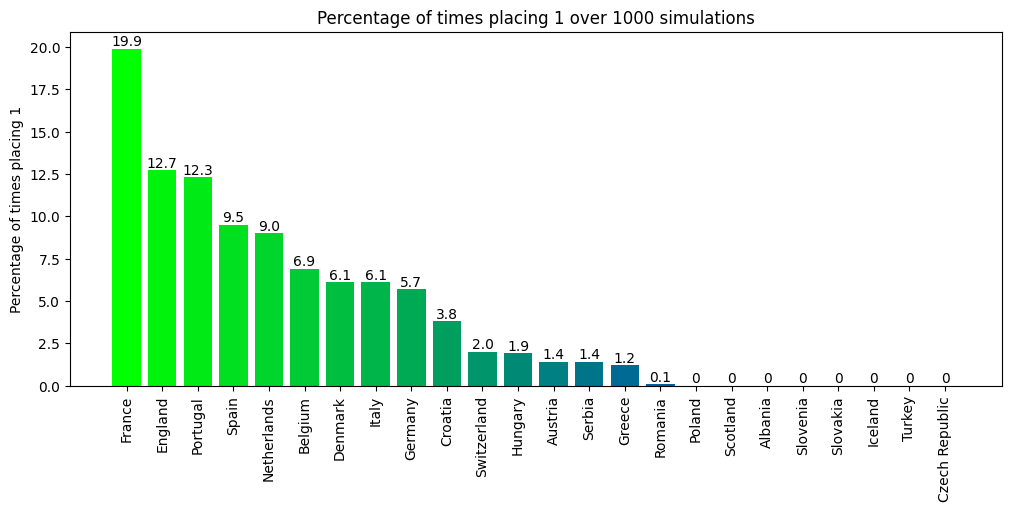

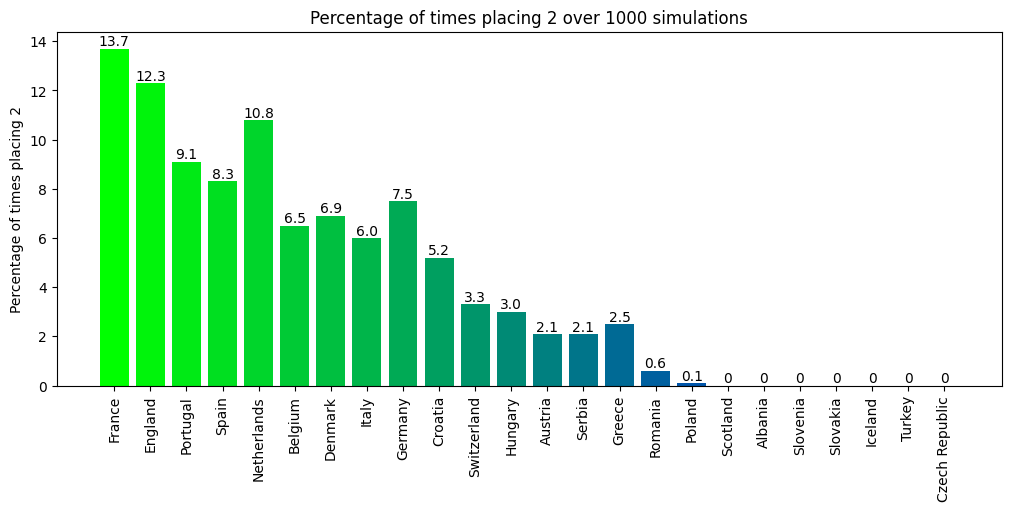

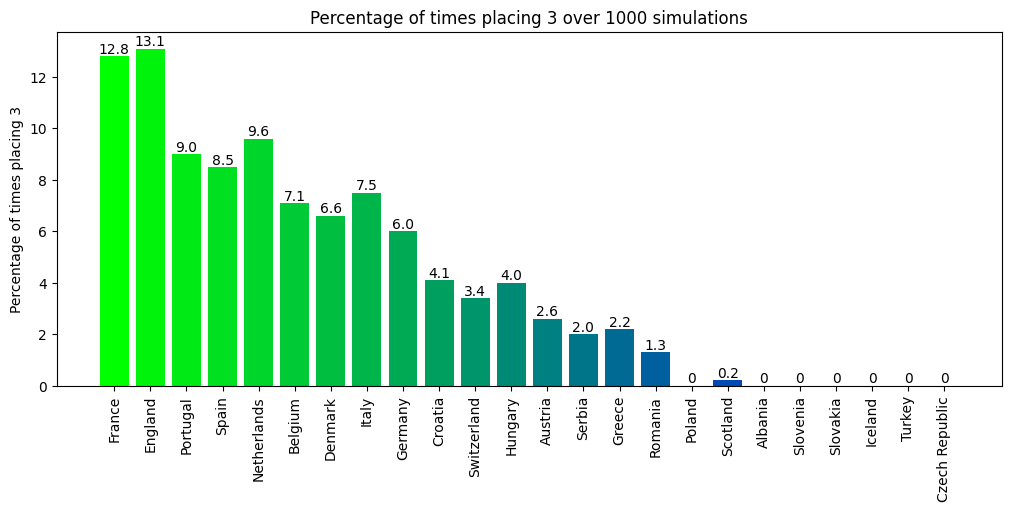

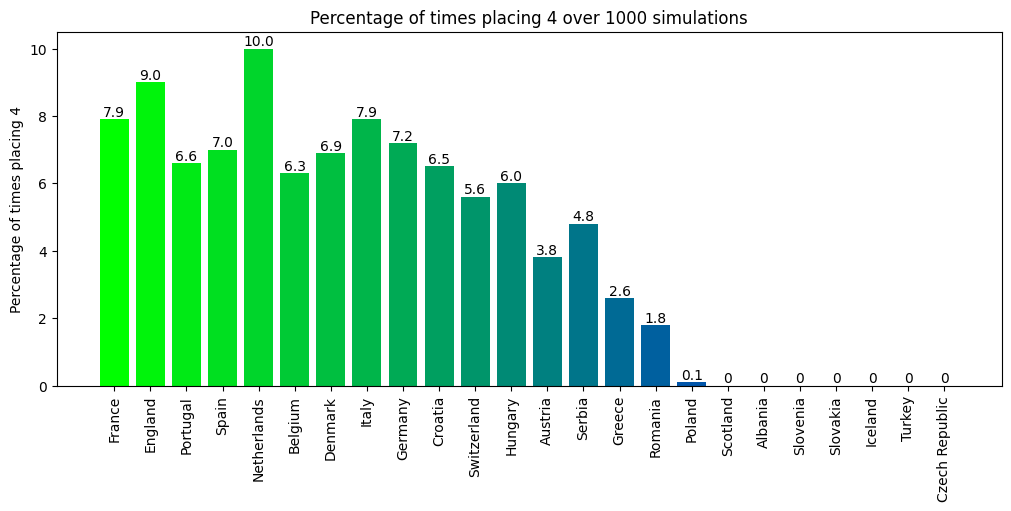

In [43]:
for i in range(4):
    fig, ax = plt.subplots(layout='constrained', figsize=(10, 5))
    rects = ax.bar(final_results.keys(), [round(a[i], 2) for a in final_results.values()], color=colors)
    ax.bar_label(rects, [round(a[i], 2) for a in final_results.values()])
    ax.set_ylabel(f'Percentage of times placing {i+1}')
    ax.set_title(f'Percentage of times placing {i+1} over {nb_iter} simulations')
    ax.tick_params(axis='x', rotation=90)

In [44]:
nb_iter = 1000
friendly_stat_team = {
    'Germany': [0, 0, 0, 0],
    'Scotland': [0, 0, 0, 0],
    'Hungary': [0, 0, 0, 0],
    'Switzerland': [0, 0, 0, 0],
    'Spain': [0, 0, 0, 0],
    'Croatia': [0, 0, 0, 0],
    'Italy': [0, 0, 0, 0],
    'Albania': [0, 0, 0, 0],
    'Slovenia': [0, 0, 0, 0],
    'Denmark': [0, 0, 0, 0],
    'Serbia': [0, 0, 0, 0],
    'England': [0, 0, 0, 0],
    'Netherlands': [0, 0, 0, 0],
    'Austria': [0, 0, 0, 0],
    'France': [0, 0, 0, 0],
    'Poland': [0, 0, 0, 0],
    'Belgium': [0, 0, 0, 0],
    'Slovakia': [0, 0, 0, 0],
    'Romania': [0, 0, 0, 0],
    'Iceland': [0, 0, 0, 0],
    'Turkey': [0, 0, 0, 0],
    'Portugal': [0, 0, 0, 0],
    'Czech Republic': [0, 0, 0, 0],
    'Greece': [0, 0, 0, 0],
}
for i in range(nb_iter):
    ratings_2024 = get_ratings(2020, 2024, friendly=True)
    print(i)
    podium = Simulator(groups=groups, ratings=ratings_2024).simulate_euro()
    for j in range(4):
        winner = podium[j]
        friendly_stat_team[winner][j] += 1 / nb_iter * 100
        #stat_team[winner][j] = stat_team[winner][j].__round__(2)

friendly_final_results = dict(sorted(friendly_stat_team.items(), key=lambda x: x[1], reverse=True))
print(friendly_final_results)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

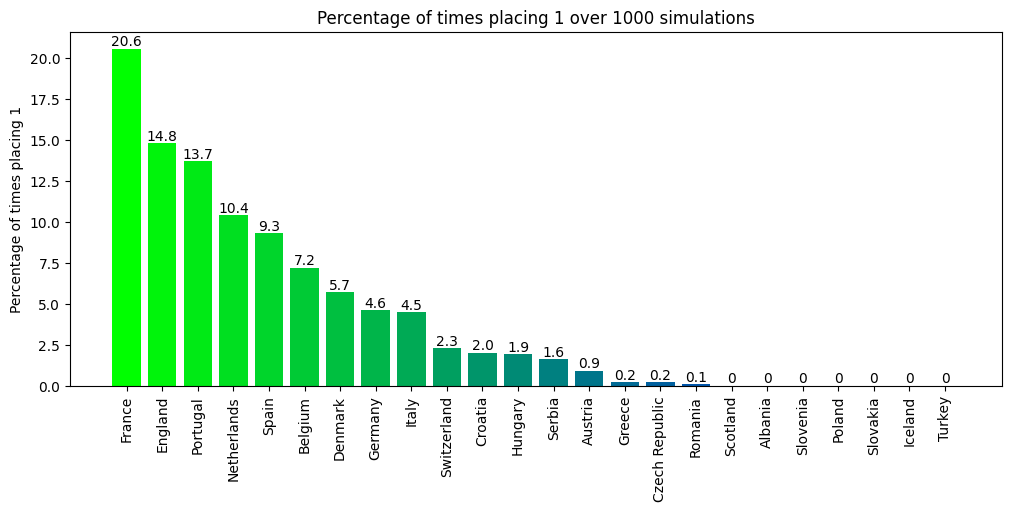

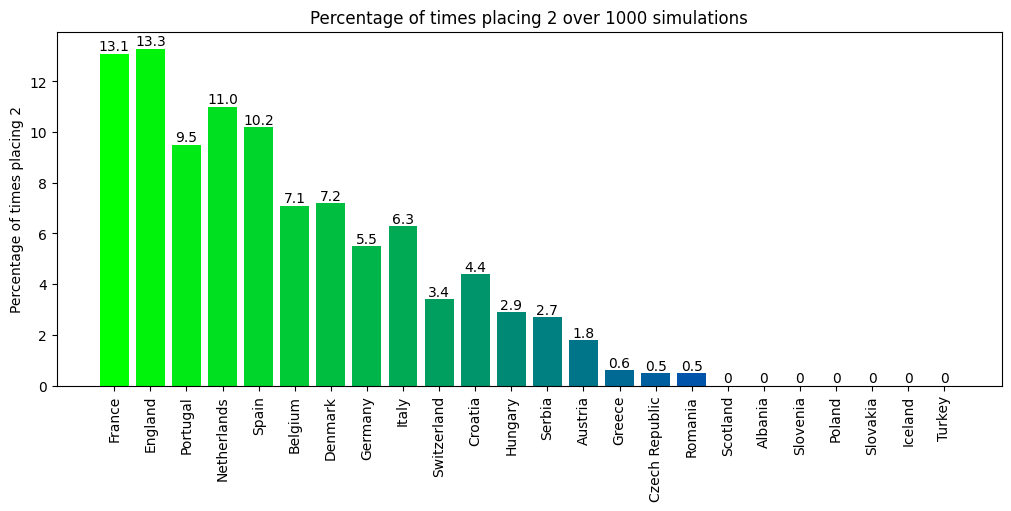

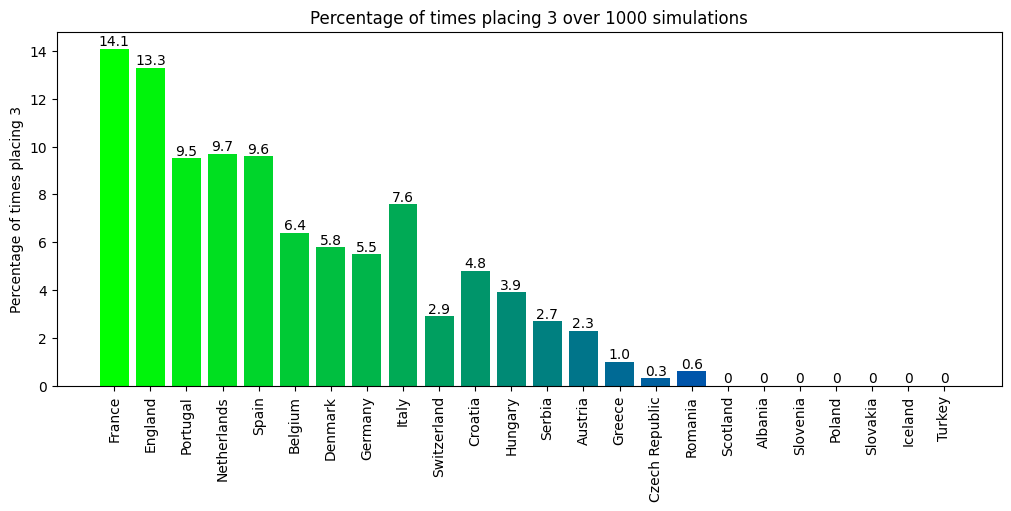

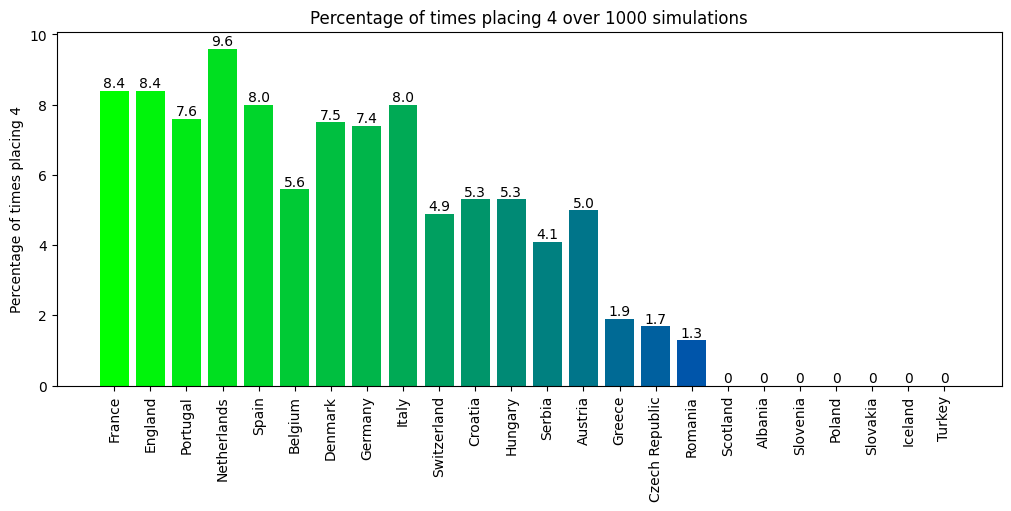

In [45]:
colors = [(0, 1 - i, i) for i in np.arange(0, 1, 1 / len(friendly_stat_team.keys()))]
for i in range(4):
    fig, ax = plt.subplots(layout='constrained', figsize=(10, 5))
    rects = ax.bar(friendly_final_results.keys(), [round(a[i], 2) for a in friendly_final_results.values()], color=colors)
    ax.bar_label(rects, [round(a[i], 2) for a in friendly_final_results.values()])
    ax.set_ylabel(f'Percentage of times placing {i + 1}')
    ax.set_title(f'Percentage of times placing {i + 1} over {nb_iter} simulations')
    ax.tick_params(axis='x', rotation=90)

In [73]:
test_groups = [
    {
        'Italy': 0,
        'Wales': 0,
        'Switzerland': 0,
        'Turkey': 0,
    },
    {
        'Belgium': 0,
        'Denmark': 0,
        'Finland': 0,
        'Russia': 0,
    },
    {
        'Netherlands': 0,
        'Austria': 0,
        'Ukraine': 0,
        'North Macedonia': 0,
    },
    {
        'England': 0,
        'Croatia': 0,
        'Czech Republic': 0,
        'Scotland': 0,
    },
    {
        'Sweden': 0,
        'Spain': 0,
        'Slovakia': 0,
        'Poland': 0,
    },
    {
        'France': 0,
        'Germany': 0,
        'Portugal': 0,
        'Hungary': 0,
    },
]

test_simulator = Simulator(groups=test_groups, ratings=get_ratings(2016, 2021))

In [75]:
# Test euro 2021
test_nb_iter = 6000
test_stat_team = {
        'Italy': [0, 0, 0, 0],
        'Wales': [0, 0, 0, 0],
        'Switzerland': [0, 0, 0, 0],
        'Turkey': [0, 0, 0, 0],
        'Belgium': [0, 0, 0, 0],
        'Denmark': [0, 0, 0, 0],
        'Finland': [0, 0, 0, 0],
        'Russia': [0, 0, 0, 0],
        'Netherlands': [0, 0, 0, 0],
        'Austria': [0, 0, 0, 0],
        'Ukraine': [0, 0, 0, 0],
        'North Macedonia': [0, 0, 0, 0],
        'England': [0, 0, 0, 0],
        'Croatia': [0, 0, 0, 0],
        'Czech Republic': [0, 0, 0, 0],
        'Scotland': [0, 0, 0, 0],
        'Sweden': [0, 0, 0, 0],
        'Spain': [0, 0, 0, 0],
        'Slovakia': [0, 0, 0, 0],
        'Poland': [0, 0, 0, 0],
        'France': [0, 0, 0, 0],
        'Germany': [0, 0, 0, 0],
        'Portugal': [0, 0, 0, 0],
        'Hungary': [0, 0, 0, 0],
    }
for i in range(test_nb_iter):
    podium = test_simulator.simulate_euro()
    #print('podium', podium)
    for j in range(4):
        winner = podium[j]
        test_stat_team[winner][j] += 1 / test_nb_iter * 100
        #stat_team[winner][j] = stat_team[winner][j].__round__(2)

test_final_results = dict(sorted(test_stat_team.items(), key=lambda x: x[1], reverse=True))
print(test_final_results)

{'France': [31.43333333333283, 21.3833333333334, 27.833333333333034, 18.866666666666877], 'Netherlands': [16.150000000000365, 25.63333333333316, 22.649999999999995, 34.266666666666005], 'Belgium': [14.43333333333363, 10.766666666666781, 15.716666666667027, 11.183333333333469], 'Spain': [13.600000000000255, 16.1333333333337, 9.400000000000047, 11.983333333333508], 'England': [12.466666666666866, 15.70000000000036, 9.283333333333374, 11.216666666666804], 'Italy': [11.866666666666836, 10.083333333333414, 14.90000000000032, 11.000000000000126], 'Switzerland': [0.03333333333333333, 0.13333333333333333, 0.08333333333333333, 0.4333333333333333], 'Germany': [0.016666666666666666, 0.05, 0.03333333333333333, 0.09999999999999999], 'Denmark': [0, 0.08333333333333333, 0.05, 0.4666666666666666], 'Croatia': [0, 0.016666666666666666, 0.03333333333333333, 0.26666666666666666], 'Wales': [0, 0.016666666666666666, 0, 0.016666666666666666], 'Portugal': [0, 0, 0.016666666666666666, 0.016666666666666666], 'S

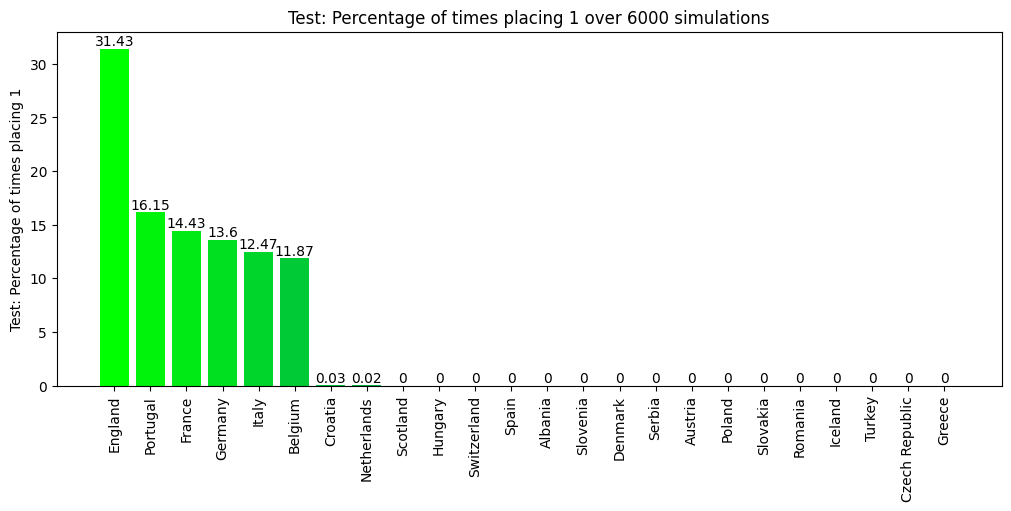

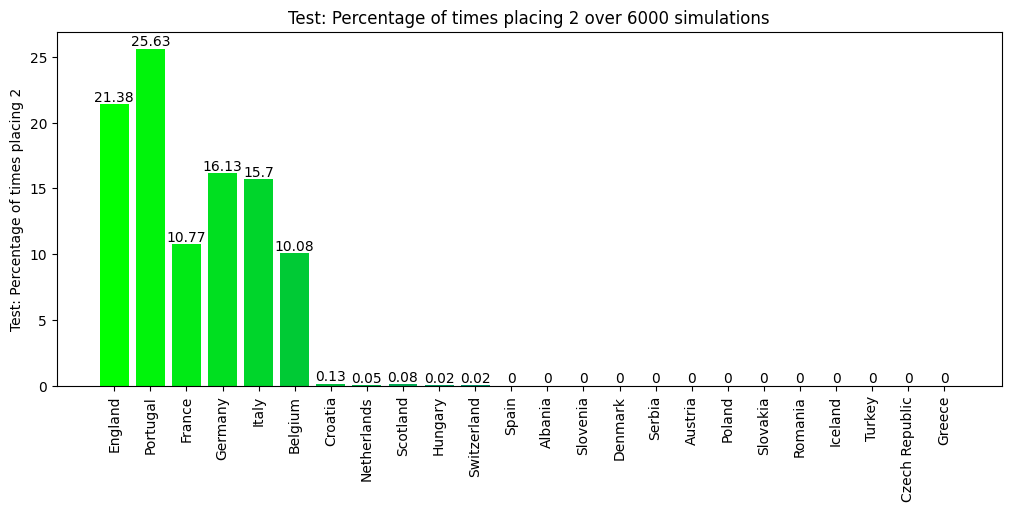

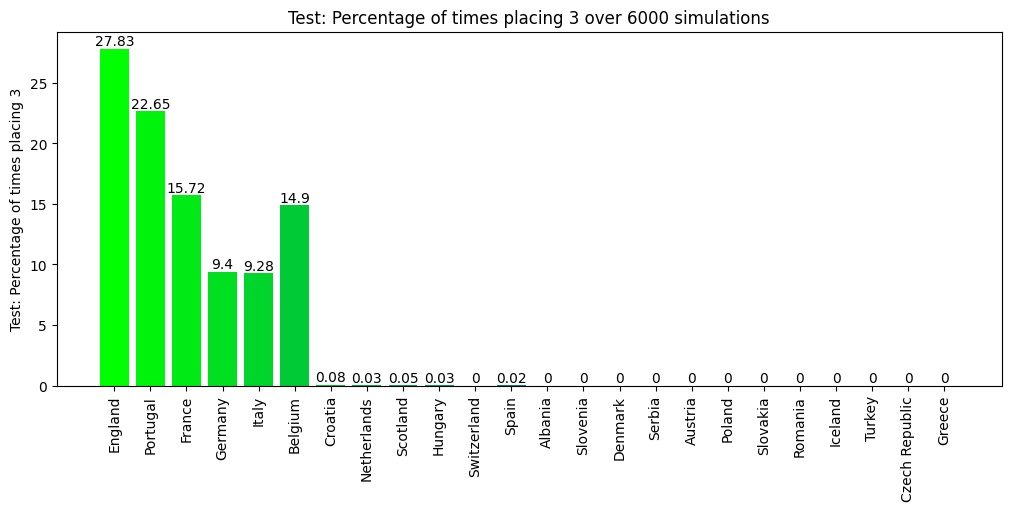

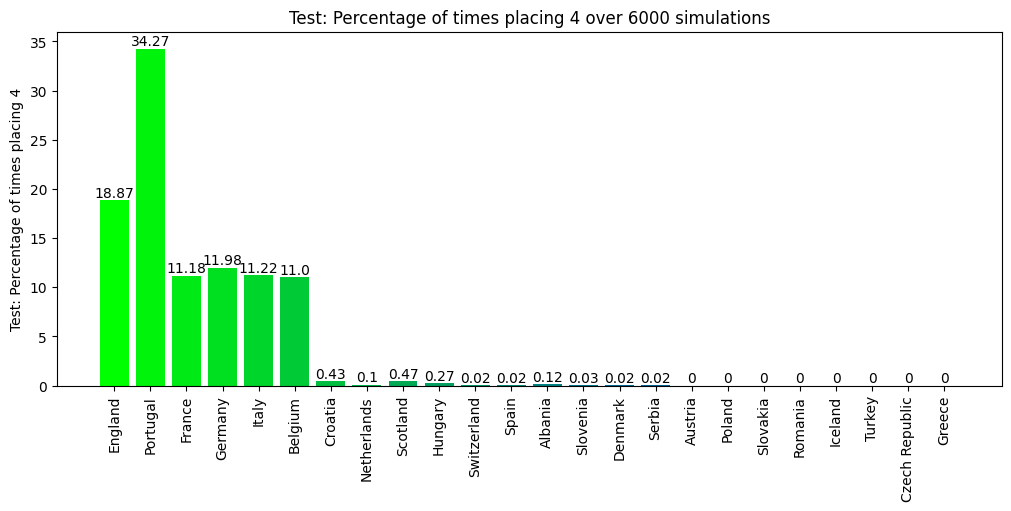

In [76]:
test_colors = [(0, 1-i, i) for i in np.arange(0,1,1/len(test_stat_team.keys()))]

for i in range(4):
    fig, ax = plt.subplots(layout='constrained', figsize=(10, 5))
    rects = ax.bar(final_results.keys(), [round(a[i], 2) for a in test_final_results.values()], color=test_colors)
    ax.bar_label(rects, [round(a[i], 2) for a in test_final_results.values()])
    ax.set_ylabel(f'Test: Percentage of times placing {i+1}')
    ax.set_title(f'Test: Percentage of times placing {i+1} over {nb_iter} simulations')
    ax.tick_params(axis='x', rotation=90)